# Decision Tree from SK Learn

In [153]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import warnings
%matplotlib inline

In [154]:
# Read in data from kaggle
# https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016/download

raw_df = pd.read_csv('../../data/suicide.csv')
raw_df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


## Data Preprocessing

In [155]:
# Remove spaces from coloumn name
raw_df.rename(columns={' gdp_for_year ($) ':'gdp_for_year ($)'}, inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

One main issue with the data is the 'HDI for year' column. This feature is the Human Development Index, which could have a notable effect on the suicide risk of a population. However, there is a significant amount of rows missing entries for this column. Therefore we decided to remove it altogether so as to not skew the learning ability of the model.

In [156]:
# Drop na values in HDI
raw_df.loc[raw_df['HDI for year'].isna(), ['country', 'year']].drop_duplicates()

,country,year
0,Albania,1987
12,Albania,1988
24,Albania,1989
36,Albania,1992
48,Albania,1993
...,...,...
27688,Uzbekistan,2001
27700,Uzbekistan,2002
27712,Uzbekistan,2003
27724,Uzbekistan,2004


In [157]:
# Still missing a lot of HDI data
# Decided to drop column so as to not skew results due to missing information in some rows
raw_df.drop(["HDI for year"], axis=1)

# Also drop country-year since it is already given in the year column
raw_df.drop(columns=['country-year'], inplace=True)
raw_df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')

Now that the data has been scrubbed, we need to create columns for our class which is the risk of suicide. For each row, if the value of 'suicides/100k' is greater than the mean of 'suicides/100k' for all rows then we'll call that a 'high' risk, if the value is less than the mean it will be labeled a 'low' risk. This will be the target column for the model.

In [158]:
# Create additional column for suicide risk and set the default value as low 
raw_df['suicide_risk'] = 'low' 

# Set the risk as high if suicides/100k pop is higher than the mean, high 
# Compare the value of suicides/100k to the mean of all suicides/100k.
# If the value is lower than the mean we'll say it is a low risk, else a high risk

raw_df.loc[raw_df['suicides/100k pop'] > raw_df['suicides/100k pop'].mean(), 'suicide_risk'] = 'high' 
raw_df['suicide_risk'].value_counts()

low     19061
high     8759
Name: suicide_risk, dtype: int64

Since we have time series data and are attempting to build a machine learning model to make predictions on the future, we need to train the model on past observations. Therefore, instead of doing a randomized 80%|10%|10% train test validate split, we will split the data by time. By taking the cumulative sum / sum of years of all the data, we can see what percentage of the data hs been collected up until a particular year. Observe the list below: ~80% of the data represents years 1985 - 2009, the next ~10% is from 2010 - 2013, and the final ~10% from 2014 - 2016.

In [159]:
# Split data into 80/10/10

train_df = raw_df.loc[raw_df['year'] <= 2009]
val_df = raw_df.loc[(raw_df['year'] >= 2010) & (raw_df['year'] <=2012)]
test_df = raw_df.loc[raw_df['year'] >= 2013]

print('train_df.shape: ', train_df.shape)
print('val_df.shape: ', val_df.shape)
print('test_df.shape: ', test_df.shape)

train_df.shape:  (21960, 12)
val_df.shape:  (3060, 12)
test_df.shape:  (2800, 12)


Noting the correlellogram from earlier, the following columns won't be useful for the algorithm:
year, suicides_no, population, suicides/100k, gpd_for_year, and generation. 

In [160]:
# Label input and target columns
input_cols = ['country', 'sex', 'age', 'gdp_per_capita ($)']
target_col = 'suicide_risk'

In [161]:
train_inputs = train_df.loc[:, input_cols]
train_target = train_df.loc[:, target_col]

val_inputs = val_df.loc[:, input_cols]
val_target = val_df.loc[:, target_col]

test_inputs = test_df.loc[:, input_cols]
test_target = test_df.loc[:, target_col]


In [162]:
numeric_cols = list(train_inputs.select_dtypes(include=np.number).columns)
categorical_cols = list(train_inputs.select_dtypes(include='object').columns)

print('numeric columns: ', numeric_cols)
print('categorical columns: ', categorical_cols)

numeric columns:  ['gdp_per_capita ($)']
categorical columns:  ['country', 'sex', 'age']


The numeric features identified in the previous step need to scaled to values from 0 to 1 to prevent particular features from having a disproportionate affect on the accuracy of the model.

In [163]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler to all the data
scaler = MinMaxScaler().fit(raw_df.loc[:, numeric_cols])

# Scale the train, validation and test sets 
train_inputs.loc[:, numeric_cols] = scaler.transform(train_inputs.loc[:, numeric_cols])
val_inputs.loc[:, numeric_cols] = scaler.transform(val_inputs.loc[:, numeric_cols])
test_inputs.loc[:, numeric_cols] = scaler.transform(test_inputs.loc[:, numeric_cols])



Finally, we need to encode the categorical columns into values of either 0 or 1 in order to use them in the algorithm.

In [164]:
# Check the number of unique values of each categorical column
raw_df[categorical_cols].nunique()

country    101
sex          2
age          6
dtype: int64

In [165]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore').fit(raw_df[categorical_cols])

*Note : the encoder used seems to raise some "DataFrame fragmented" warnings. This can cause performance issues for extremely large datasets, but has not made a significant effect on this analysis.*

In [166]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

# Encode the columns
train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
val_inputs[encoded_cols] = encoder.transform(val_inputs.loc[:, categorical_cols]).toarray()
test_inputs[encoded_cols] = encoder.transform(test_inputs.loc[:, categorical_cols]).toarray()

C:\Users\Travis\anaconda3\envs\geo_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs.loc[:, categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\2917261160.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [167]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

### SK Learn Decision Tree

#### Training
Let's train a decision tree model on the train set.

In [168]:
# Let's use the decision tree from sk learn
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, train_target)

DecisionTreeClassifier(random_state=1)

#### Accuracy
Check the accuracy score using SK Learn's accuracy package.
We see the accuracy on train = 1.0, test = 0.9182142857142858, validate = 0.9316993464052288.

In [169]:
from sklearn.metrics import accuracy_score, confusion_matrix

train_pred = tree.predict(X_train)
accuracy_score(train_target, train_pred)

1.0

In [170]:
test_pred = tree.predict(X_test)
accuracy_score(test_target, test_pred)

0.9182142857142858

In [171]:
val_pred = tree.predict(X_val)
accuracy_score(val_target, val_pred)

0.9316993464052288

#### Visualization
SK learn has a built-in function to visualize the decision tree. A nice feature of the function is that it displays the Gini index, sample counts and the counts for splits on the categories. 

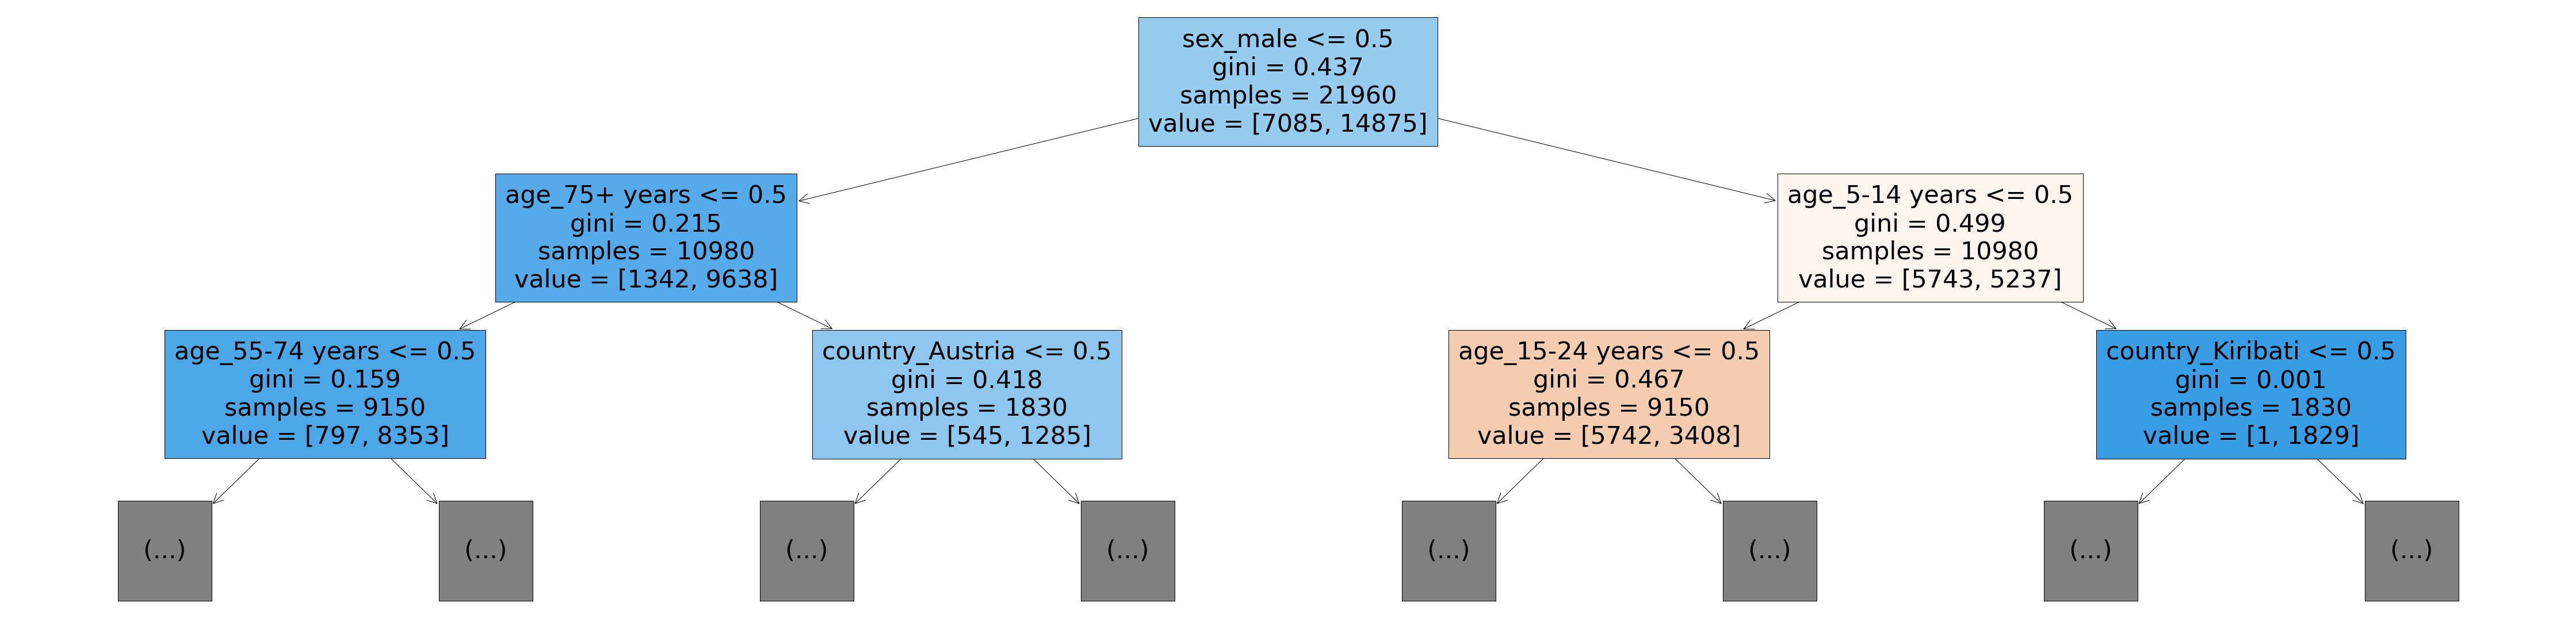

In [172]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80, 20))
plot_tree(tree, feature_names=X_train.columns, max_depth=2, filled=True);

#### Feature Importance
SK Learn's Decision Tree classifier has a built-in function that allows us to examine the importance of each feature via the Gini index. 

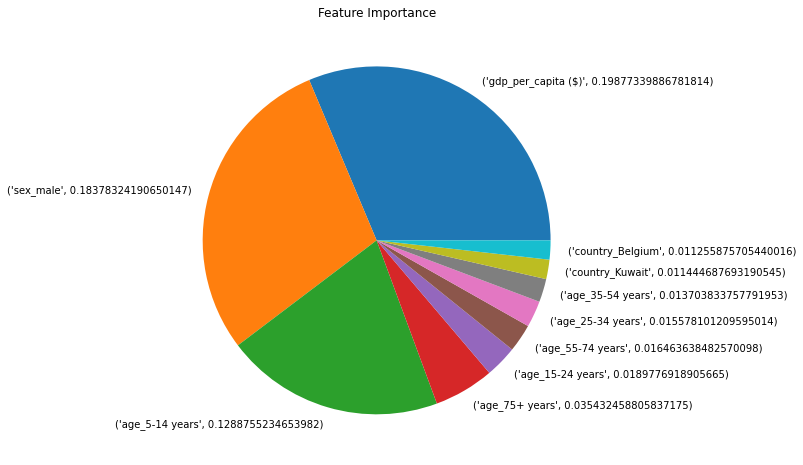

In [173]:
plt.figure(figsize=(10, 8));
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_}).sort_values(by='importance', ascending=False)

# Representation of feature importance in a pie chart 
labels = list(zip(importance['feature'].head(10).values, importance['importance'].head(10).values))
plt.pie(x=importance['importance'].head(10), labels=labels );
plt.title("Feature Importance");

The features with the most influence when predicting a high or low suicide risk are gdp_per_capita, sex_male, and age_5-14_years. Referring back to the age and gender distribution bar chart from the exploratory data analysis, it is clear to see that males have a higher amount of suicides than females. Also note that the 5-14 age group has the fewest amount of suicides. The 4th highest importance feature is also noteworthy, age_75+_ years, because it is the age group with the highest risk. 

### Hyperparameter Tuning

Let's look at the hyperparameters max_depth and min_samples_split. Max_depth determines the maximum tree height, or in other words how complex the decision tree is. The deeper the tree the closer it gets to being overfitted. Min_samples_split is the minimum number of samples required to split an internal node.

#### Max Tree Depth

In [174]:
# Current max_depth of tree
tree.tree_.max_depth

69

In [175]:
# Let's test from a minimum depth of 2, incrementing by 2 to 42 
acc_results = []

for depth in range(2, 43, 2):
    tree = DecisionTreeClassifier(random_state=1, max_depth=depth)
    tree.fit(X_train, train_target)
    
    train_pred = tree.predict(X_train)
    val_pred = tree.predict(X_val)
    
    train_acc = accuracy_score(train_target, train_pred)
    val_acc = accuracy_score(val_target, val_pred)
    
    acc_results.append({'max_depth': depth, 'train_acc': train_acc, 'val_acc':val_acc})

In [176]:
# Creating a dataframe from accuracy results for ease of plotting
acc_df = pd.DataFrame(data=acc_results)

# Find best accuracy value and location
best_depth = acc_df['val_acc'].max()
bd_loc = acc_df['val_acc'].idxmax()

train_loc = acc_df['train_acc'][bd_loc]

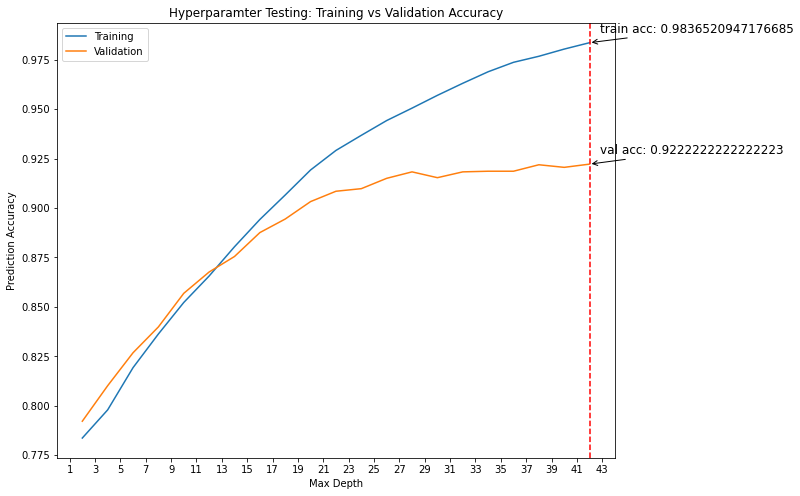

In [177]:
# Create a line plot to visualize training error and validation error against max_depth
plt.figure(figsize=(10, 8));
#fig, ax = plt.subplots();
# sns.lineplot(data=acc_df, x='max_depth', y='train_acc', ax=ax);
# sns.lineplot(data=acc_df, x='max_depth', y='val_acc', ax=ax);

plt.plot(acc_df['max_depth'], acc_df['train_acc']);
plt.plot(acc_df['max_depth'], acc_df['val_acc']);
plt.ylabel('Prediction Accuracy');
plt.xlabel('Max Depth')
plt.xticks(range(1, 44, 2));
plt.title('Hyperparamter Testing: Training vs Validation Accuracy');
plt.legend(['Training', 'Validation']);

# Annotate the training error and validation error 
plt.axvline(x=(bd_loc+1) * 2, color='r', linestyle='--');
plt.annotate(f'val acc: {best_depth}',
            xy=((bd_loc+1) * 2, best_depth),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.annotate(f'train acc: {train_loc}',
            xy=((bd_loc+1) * 2, acc_df['train_acc'][bd_loc]),
            xycoords='data',
            fontsize=12,
            xytext=(10, 10),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black',
                            connectionstyle="arc3"));
plt.show();


The best accuracy on the validation set is at max_depth = 38. Let's use this value versus the probably overfitted value of 69. The accuracy is still very good at ~92% as opposed to ~93% before.

#### Minimum Samples Split
As mentioned earlier, the min_samples_split is the minimum number of samples in an internal node that is required to split that node. Gini impurity is used to calculate how "pure" a node is, that is how many samples are in the node upon creation of the node. The formula is denoted by 

![G = 1 - summation from k = 1 to n of p sub k squared](https://miro.medium.com/max/466/1*UNszwSYfUJFHtfC0jvBKsw@2x.png)

where p[k] is the fraction of samples belonging to class k. 

Sklearn's GridSearchCV function helps automate the process of finding the best combination of hyperparameters by trainging a Decision Tree model on a range of max_depths and min_samples_split and keeping track of the best performers. 

In [178]:
# Create hyperparameter ranges for GridSearchCV
param_dict = {
    "max_depth": range(2, 40, 2),
    "min_samples_split": range(2, 10, 2)
}

# GSCV splits the data itself so we have to concat it back together
X = pd.concat([X_train, X_val])
Y = pd.concat([train_target, val_target])

from sklearn.model_selection import GridSearchCV

# Using the grid
# GridSearchCV returns 
tree = DecisionTreeClassifier(random_state=1)
grid = GridSearchCV(tree, param_grid=param_dict)
grid.fit(X, Y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': range(2, 40, 2),
                         'min_samples_split': range(2, 10, 2)})

In [179]:
# Access logs from the grid search
print('best params: ', grid.best_params_)
print('accuracy score: ', grid.best_score_)

best params:  {'max_depth': 38, 'min_samples_split': 6}
accuracy score:  0.859312549960032


In [180]:
# Test predictions on the best model determined by the grid search
test_pred = grid.predict(X_test)
accuracy_score(test_target, test_pred)

0.9225

In [181]:
val_pred = grid.predict(X_val)
accuracy_score(val_target, val_pred)

0.961437908496732

After hyperparamter tuning, the model has a significantly improved accuracy of ~96%!. Let's use the model to make some predictions.
#### Predictions
*Note: Please ignore warnings, performance was not significantly affected in the following tasks.*

In [187]:
# Create a sample input for the model to predict a high or low suicide risk
new_input = {
    'country': 'Republic of Korea',
    'year': 2020,
    'sex': 'male',
    'age': '75+ years',
    'suicides_no': 1400,
    'population': 900000,
    'suicides/100k pop': 155.55,
    'HDI for year': 0.9,
    'gdp_for_year ($)': '1,000,000,000',
    'gdp_per_capita ($)': 29000,
    'generation': 'Silent' 
}

# Encode the input to the proper format to be run in the model
input_df = pd.DataFrame([new_input])
input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()

X_input = input_df[numeric_cols + encoded_cols]
pred = grid.predict(X_input)[0]
prob = grid.predict_proba(X_input)[0][list(grid.classes_).index(pred)]

C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\188150098.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [191]:
print("Suicice Risk, Probability: ", pred, prob)

Suicice Risk, Probability:  low 1.0


In [189]:
# Create a sample input for the model to predict a high or low suicide risk
new_input_2 = {
    'country': 'Singapore',
    'year': 2020,
    'sex': 'female',
    'age': '15-24 years',
    'suicides_no': 14,
    'population': 250000,
    'suicides/100k pop': 5.6,
    'HDI for year': 0.7,
    'gdp_for_year ($)': '300,000,000,000',
    'gdp_per_capita ($)': 80000,
    'generation': 'Millenials' 
}

# Encode the input to the proper format to be run in the model
input_df = pd.DataFrame([new_input_2])
input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()

X_input = input_df[numeric_cols + encoded_cols]
pred = grid.predict(X_input)[0]
prob = grid.predict_proba(X_input)[0][list(grid.classes_).index(pred)]

C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols]).toarray()
C:\Users\Travis\AppData\Local\Temp\ipykernel_20208\3156601195.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [192]:
print("Suicice Risk, Probability: ", pred, prob)

Suicice Risk, Probability:  low 1.0


##### The model performed accurately, outputting expected results.